## QDM correction to CESM2-WACCM historical TF
This code applies a Quantile Delta Mapping (QDM) bias correction to the historical period of ocean thermal forcing generated with CESM2-WACCM output.  The basis of the QDM correction is the EN4 reanalysis.  We take the 30-year period from 1985-2014 as the climatological baseline for this correction.

CESM2-WACCM is in a rotated polar grid with dimensions `nlat, nlon` rather than `lat, lon`.  Use xESMF to regrid this to match EN4 grid before applying QDM bias correction.  Note: depth/`lev` variable is in cm rather than m by default.  This is corrected in the current code; if you've changed the variable in an earlier processing step, you'll want to adjust accordingly here.


16 Jul 2025 | EHU
- 29 Jul 2025: Use dask for increased efficiency.  Resample EN4 to CESM depth levels rather than vice versa.  Dask doesn't actually help, so try xESMF instead.  This seems *much* more efficient.
- 31 Jul 2025: Read in historical and SSP5-8.5 together, so that we can use historical baseline period for QDM correction on the projection. Try with additive QDM instead, given output has some discrepancies in future and historical series that seem multiplicative in nature.
- 27 Aug 2025: Output from this step has missing data in central coasts of Greenland, inc. around Sermeq Kujalleq.  Check for buggy trimming, regridding errors, etc.
- 18 Sept 2025: Continue work on regridding bug.  Look for lat/lon transposition.  Re-shape the EN4 and CESM datasets because xESMF.regridder is expecting broadcasted dimensions to be *on the left*.
- 19 Sept: Read in data that Donald has pre-gridded to rectangular 40 km grid (EPSG:3413).  Abandon xESMF.  Test QDM.

In [1]:
import os
import sys
import copy
import csv
import time
import datetime
import math
# import dask
import cartopy.crs as ccrs ## map projections
import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe ## more powerful regridding
import netCDF4 as nc
import matplotlib.pyplot as plt

import rioxarray
from rioxarray.rioxarray import affine_to_coords
from pyproj import CRS

In [2]:
## from cmethods.utils
import warnings
from typing import TYPE_CHECKING, Optional, Union, TypeVar

XRData_t = (xr.Dataset, xr.DataArray)
NPData_t = (list, np.ndarray, np.generic)
XRData = TypeVar("XRData", xr.Dataset, xr.DataArray)
NPData = TypeVar("NPData", list, np.ndarray, np.generic)
MAX_SCALING_FACTOR = 2 ## to allow multiplicative correction?


def check_xr_types(obs: XRData, simh: XRData, simp: XRData) -> None:
    """
    Checks if the parameters are in the correct type. **only used internally**
    """
    phrase: str = "must be type xarray.core.dataarray.Dataset or xarray.core.dataarray.DataArray"

    if not isinstance(obs, XRData_t):
        raise TypeError(f"'obs' {phrase}")
    if not isinstance(simh, XRData_t):
        raise TypeError(f"'simh' {phrase}")
    if not isinstance(simp, XRData_t):
        raise TypeError(f"'simp' {phrase}")

def check_np_types(
    obs: NPData,
    simh: NPData,
    simp: NPData,
) -> None:
    """
    Checks if the parameters are in the correct type. **only used internally**
    """
    phrase: str = "must be type list, np.ndarray or np.generic"

    if not isinstance(obs, NPData_t):
        raise TypeError(f"'obs' {phrase}")
    if not isinstance(simh, NPData_t):
        raise TypeError(f"'simh' {phrase}")
    if not isinstance(simp, NPData_t):
        raise TypeError(f"'simp' {phrase}")

def nan_or_equal(value1: float, value2: float) -> bool:
    """
    Returns True if the values are equal or at least one is NaN

    :param value1: First value to check
    :type value1: float
    :param value2: Second value to check
    :type value2: float
    :return: If any value is NaN or values are equal
    :rtype: bool
    """
    return np.isnan(value1) or np.isnan(value2) or value1 == value2
        
def ensure_dividable(
    numerator: Union[float, np.ndarray],
    denominator: Union[float, np.ndarray],
    max_scaling_factor: float,
) -> np.ndarray:
    """
    Ensures that the arrays can be divided. The numerator will be multiplied by
    the maximum scaling factor of the CMethods class if division by zero.

    :param numerator: Numerator to use
    :type numerator: np.ndarray
    :param denominator: Denominator that can be zero
    :type denominator: np.ndarray
    :return: Zero-ensured division
    :rtype: np.ndarray | float
    """
    with np.errstate(divide="ignore", invalid="ignore"):
        result = numerator / denominator

    if isinstance(numerator, np.ndarray):
        mask_inf = np.isinf(result)
        result[mask_inf] = numerator[mask_inf] * max_scaling_factor  # type: ignore[index]

        mask_nan = np.isnan(result)
        result[mask_nan] = 0  # type: ignore[index]
    elif np.isinf(result):
        result = numerator * max_scaling_factor
    elif np.isnan(result):
        result = 0.0

    return result

def get_pdf(
    x: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Compuites and returns the the probability density function :math:`P(x)`
    of ``x`` based on ``xbins``.

    :param x: The vector to get :math:`P(x)` from
    :type x: list | np.ndarray
    :param xbins: The boundaries/bins of :math:`P(x)`
    :type xbins: list | np.ndarray
    :return: The probability densitiy function of ``x``
    :rtype: np.ndarray

    .. code-block:: python
        :linenos:
        :caption: Compute the probability density function :math:`P(x)`

        >>> from cmethods get_pdf

        >>> x = [1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10]
        >>> xbins = [0, 3, 6, 10]
        >>> print(get_pdf(x=x, xbins=xbins))
        [2, 5, 5]
    """
    pdf, _ = np.histogram(x, xbins)
    return pdf


def get_cdf(
    x: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Computes and returns returns the cumulative distribution function :math:`F(x)`
    of ``x`` based on ``xbins``.

    :param x: Vector to get :math:`F(x)` from
    :type x: list | np.ndarray
    :param xbins: The boundaries/bins of :math:`F(x)`
    :type xbins: list | np.ndarray
    :return: The cumulative distribution function of ``x``
    :rtype: np.ndarray


    .. code-block:: python
        :linenos:
        :caption: Compute the cumulative distribution function :math:`F(x)`

        >>> from cmethods.utils import get_cdf

        >>> x = [1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10]
        >>> xbins = [0, 3, 6, 10]
        >>> print(get_cdf(x=x, xbins=xbins))
        [0.0, 0.16666667, 0.58333333, 1.]
    """
    pdf, _ = np.histogram(x, xbins)
    cdf = np.insert(np.cumsum(pdf), 0, 0.0)
    return cdf / cdf[-1]


def get_inverse_of_cdf(
    base_cdf: Union[list, np.ndarray],
    insert_cdf: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Returns the inverse cumulative distribution function as:
    :math:`F^{-1}_{x}\left[y\right]` where :math:`x` represents ``base_cdf`` and
    ``insert_cdf`` is represented by :math:`y`.

    :param base_cdf: The basis
    :type base_cdf: list | np.ndarray
    :param insert_cdf: The CDF that gets inserted
    :type insert_cdf: list | np.ndarray
    :param xbins: Probability boundaries
    :type xbins: list | np.ndarray
    :return: The inverse CDF
    :rtype: np.ndarray
    """
    return np.interp(insert_cdf, base_cdf, xbins)


In [3]:
def quantile_delta_mapping(
    obs: NPData,
    simh: NPData,
    simp: NPData,
    n_quantiles: int,
    kind: str = "+",
    **kwargs,
    ) -> NPData:
    r"""
    Based on https://python-cmethods.readthedocs.io/en/latest/methods.html#quantile-delta-mapping

    kind: str, default + for additive, can be set to * for multiplicative
    """
    # check_adjust_called(
    #     function_name="quantile_delta_mapping",
    #     adjust_called=kwargs.get("adjust_called"),
    # )
    check_np_types(obs=obs, simh=simh, simp=simp)

    if not isinstance(n_quantiles, int):
        raise TypeError("'n_quantiles' must be type int")

    if kind=='+':
        obs, simh, simp = (
            np.array(obs),
            np.array(simh),
            np.array(simp),
        )  # to achieve higher accuracy
        global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
        global_min = kwargs.get("global_min", min(np.nanmin(obs), np.nanmin(simh)))

        if nan_or_equal(value1=global_max, value2=global_min):
            return simp

        wide = abs(global_max - global_min) / n_quantiles
        xbins = np.arange(global_min, global_max + wide, wide)

        cdf_obs = get_cdf(obs, xbins)
        cdf_simh = get_cdf(simh, xbins)
        cdf_simp = get_cdf(simp, xbins)

        # calculate exact CDF values of $F_{sim,p}[T_{sim,p}(t)]$
        epsilon = np.interp(simp, xbins, cdf_simp)  # Eq. 1.1
        QDM1 = get_inverse_of_cdf(cdf_obs, epsilon, xbins)  # Eq. 1.2
        delta = simp - get_inverse_of_cdf(cdf_simh, epsilon, xbins)  # Eq. 1.3
        return QDM1 + delta  # Eq. 1.4

    if kind=='*':
        obs, simh, simp = np.array(obs), np.array(simh), np.array(simp)
        global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
        global_min = kwargs.get("global_min", 0.0)
        if nan_or_equal(value1=global_max, value2=global_min):
            return simp

        wide = global_max / n_quantiles
        xbins = np.arange(global_min, global_max + wide, wide)

        cdf_obs = get_cdf(obs, xbins)
        cdf_simh = get_cdf(simh, xbins)
        cdf_simp = get_cdf(simp, xbins)

        epsilon = np.interp(simp, xbins, cdf_simp)  # Eq. 1.1
        QDM1 = get_inverse_of_cdf(cdf_obs, epsilon, xbins)  # Eq. 1.2

        delta = ensure_dividable(  # Eq. 2.3
            simp,
            get_inverse_of_cdf(cdf_simh, epsilon, xbins),
            max_scaling_factor=kwargs.get(
                "max_scaling_scaling",
                MAX_SCALING_FACTOR,
            ),
        )
        return QDM1 * delta  # Eq. 2.4
    raise NotImplementedError(
        f"{kind=} not available for quantile_delta_mapping. Use '+' or '*' instead.",
    )


def apply_cmfunc(
    method: str,
    obs: XRData,
    simh: XRData,
    simp: XRData,
    **kwargs: dict,
) -> XRData:
    """
    Internal function used to apply the bias correction technique to the
    passed input data.
    """
    ## hard-code the QDM method
    if method!='quantile_delta_mapping':
        raise UnknownMethodError('Not implemented for methods other than quantile_delta_mapping')
        ## give this a default for what we want to do
    else:
        method='quantile_delta_mapping' ## not actually going to use this
    
    check_xr_types(obs=obs, simh=simh, simp=simp)
    # if method not in __METHODS_FUNC__:
    #     raise UnknownMethodError(method, __METHODS_FUNC__.keys())

    if kwargs.get("input_core_dims"):
        if not isinstance(kwargs["input_core_dims"], dict):
            raise TypeError("input_core_dims must be an object of type 'dict'")
        if not len(kwargs["input_core_dims"]) == 3 or any(
            not isinstance(value, str) for value in kwargs["input_core_dims"].values()
        ):
            raise ValueError(
                'input_core_dims must have three key-value pairs like: {"obs": "time", "simh": "time", "simp": "time"}',
            )

        input_core_dims = kwargs.pop("input_core_dims")
    else:
        input_core_dims = {"obs": "time", "simh": "time", "simp": "time"}

    result: XRData = xr.apply_ufunc(
        quantile_delta_mapping,
        obs,
        simh,
        # Need to spoof a fake time axis since 'time' coord on full dataset is
        # different than 'time' coord on training dataset.
        simp.rename({input_core_dims["simp"]: "__t_simp__"}),
        dask="parallelized",
        vectorize=True,
        # This will vectorize over the time dimension, so will submit each grid
        # cell independently
        input_core_dims=[
            [input_core_dims["obs"]],
            [input_core_dims["simh"]],
            ["__t_simp__"],
        ],
        # Need to denote that the final output dataset will be labeled with the
        # spoofed time coordinate
        output_core_dims=[["__t_simp__"]],
        kwargs=dict(kwargs),
    )

    # Rename to proper coordinate name.
    result = result.rename({"__t_simp__": input_core_dims["simp"]})

    # ufunc will put the core dimension to the end (time), so want to preserve
    # original order where time is commonly first.
    return result.transpose(*obs.rename({input_core_dims["obs"]: input_core_dims["simp"]}).dims)


In [4]:
## Time utils from Bryan Riel
## pasting stuff from iceutils below.
#-*- coding: utf-8 -*-

def tdec2datestr(tdec_in, returndate=False):
    """
    Convert a decimaly year to an iso date string.
    """
    if isinstance(tdec_in, (list, np.ndarray)):
        tdec_list = copy.deepcopy(tdec_in)
    else:
        tdec_list = [tdec_in]
    current_list = []
    for tdec in tdec_list:
        year = int(tdec)
        yearStart = datetime.datetime(year, 1, 1)
        if year % 4 == 0:
            ndays_in_year = 366.0
        else:
            ndays_in_year = 365.0
        days = (tdec - year) * ndays_in_year
        seconds = (days - int(days)) * 86400
        tdelta = datetime.timedelta(days=int(days), seconds=int(seconds))
        current = yearStart + tdelta
        if not returndate:
            current = current.isoformat(' ').split()[0]
        current_list.append(current)

    if len(current_list) == 1:
        return current_list[0]
    else:
        return np.array(current_list)


def datestr2tdec(yy=0, mm=0, dd=0, hour=0, minute=0, sec=0, microsec=0, dateobj=None):
    """
    Convert year, month, day, hours, minutes, seconds to decimal year.
    """
    if dateobj is not None:
        if type(dateobj) == str:
            yy, mm, dd = [int(val) for val in dateobj.split('-')]
            hour, minute, sec = [0, 0, 0]
        elif type(dateobj) == datetime.datetime:
            attrs = ['year', 'month', 'day', 'hour', 'minute', 'second']
            yy, mm, dd, hour, minute, sec = [getattr(dateobj, attr) for attr in attrs]
        elif type(dateobj) == np.datetime64:
            yy = dateobj.astype('datetime64[Y]').astype(int) + 1970
            mm = dateobj.astype('datetime64[M]').astype(int) % 12 + 1
            days = (
                (dateobj - dateobj.astype('datetime64[M]')) / np.timedelta64(1, 'D')
            )
            dd = int(days) + 1
            hour, minute, sec = [0, 0, 0]
        else:
            raise NotImplementedError('dateobj must be str, datetime, or np.datetime64.')

    # Make datetime object for start of year
    yearStart = datetime.datetime(yy, 1, 1, 0, 0, 0)
    # Make datetime object for input time
    current = datetime.datetime(yy, mm, dd, hour, minute, sec, microsec)
    # Compute number of days elapsed since start of year
    tdelta = current - yearStart
    # Convert to decimal year and account for leap year
    if yy % 4 == 0:
        return float(yy) + tdelta.total_seconds() / (366.0 * 86400)
    else:
        return float(yy) + tdelta.total_seconds() / (365.0 * 86400)

### Load in data

In [5]:
SelModel = 'CESM2-WACCM'
BaselinePeriod = ['1985','2014'] ## climatological baseline for QDM
YearsIncluded = ['1850', '2100'] ## set these to the endpoints if you want to slice the CESM2 data.
PressureIncluded = True ## whether to use files that already account for pressure effect on freezing point
## EN4 data run 1950-2014, but we will use it only during the BaselinePeriod anyway

DirSave = f'/Users/eultee/Desktop/'
DirIn = f'/Users/eultee/Desktop/'
if PressureIncluded:
    DirIn = DirIn + f'/TF-PressureIncluded/'
else:
    # DirIn = DirIn + f'/FP_in_Step3/'
    print('Confirm pressure handling in your dataset and set the read-in directory accordingly.')

DirHadley = f'/Users/eultee/Desktop/TF-PressureIncluded'
HadleyFile = f'/tf-Hadley-1950_2020_regrid.nc'

In [6]:
## Load EN4 using xarray
ds1 = xr.open_dataset(DirHadley+HadleyFile, decode_times='timeDim')
ds1
# ds2 = ds.assign_coords({'timeDim': ds.time, 
#                   'latDim': ds.lat, 
#                   'lonDim': ds.lon,
#                   'depthDim': ds.depth})

# tfEN4 = ds2.tfdpavg0to500_bathymin100.rename({'timeDim': 'time',
#                                               'latDim': 'lat',
#                                               'lonDim': 'lon'})

<xarray.Dataset> Size: 439MB
Dimensions:  (time: 852, depth: 41, y: 73, x: 43)
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-01-16T12:00:00 ... 2020-12-16T12:...
  * depth    (depth) float32 164B 0.0 50.0 100.0 ... 1.9e+03 1.95e+03 2e+03
  * y        (y) float32 292B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
  * x        (x) float32 172B -7.2e+05 -6.8e+05 -6.4e+05 ... 9.2e+05 9.6e+05
    lat      (y, x) float32 13kB ...
    lon      (y, x) float32 13kB ...
Data variables:
    TF       (time, depth, y, x) float32 439MB ...

In [7]:
## load in CESM TF for all time slices available, using multifile dataset
ds3 = xr.open_mfdataset(f'{DirIn}/TF_Omon_CESM2*.nc').sel(time=slice(YearsIncluded[0], YearsIncluded[1]))
ds3

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 3012, depth: 41, y: 73, x: 43)
Coordinates:
  * time     (time) object 24kB 1850-01-15 13:00:00.000008 ... 2100-12-15 12:...
  * depth    (depth) float32 164B 0.0 50.0 100.0 ... 1.9e+03 1.95e+03 2e+03
  * y        (y) float32 292B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
  * x        (x) float32 172B -7.2e+05 -6.8e+05 -6.4e+05 ... 9.2e+05 9.6e+05
    lat      (y, x) float32 13kB dask.array<chunksize=(73, 43), meta=np.ndarray>
    lon      (y, x) float32 13kB dask.array<chunksize=(73, 43), meta=np.ndarray>
Data variables:
    TF       (time, depth, y, x) float32 2GB dask.array<chunksize=(660, 14, 25, 11), meta=np.ndarray>

In [8]:
# with dask.config.set(**{'array.slicing.split_large_chunks': True}): ## mitigate performance problem with slicing
ds_m = ds3.where(ds3.TF<1e20)
ds_m.mean().compute()

<xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    TF       float32 4B 7.493

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_24490/14849400.py:29: RuntimeWarning: All-NaN slice encountered
  global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_24490/14849400.py:30: RuntimeWarning: All-NaN slice encountered
  global_min = kwargs.get("global_min", min(np.nanmin(obs), np.nanmin(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_24490/3349435054.py:146: RuntimeWarning: invalid value encountered in divide
  return cdf / cdf[-1]
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_24490/14849400.py:29: RuntimeWarning: All-NaN slice encountered
  global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_24490/14849400.py:30: RuntimeWarning: All-NaN slice encountered
  global_min = kwargs.get("global_min", min(np.nanmin(obs), np.nanmin(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0

Depth resampling seemed to be smearing fill value across depth levels, so that the mean of depth-resampled dataset was ~5e17, even when fill values masked out.  Created `ds_m`  before resampling to address this issue.

## Express CESM2 depth in m, then resample EN4 to same depth levels
19 Sept: not necessary with Donald's method.  Already on consistent depth levels.

In [9]:
# ## resample CESM to Hadley depths?
# tf_CESM_inM = ds_m.assign_coords(new_depth = ('lev', ds3.indexes['lev'].values*0.01))
# tf_CESM_inM = tf_CESM_inM.drop_indexes('lev')
# tf_CESM_inM = tf_CESM_inM.set_xindex('new_depth').drop_vars('lev')
# tf_CESM_inM = tf_CESM_inM.rename({'new_depth': 'lev'})
# tf_CESM_inM

In [10]:
# tfCESM_renamed = tf_CESM_inM.rename({'lev': 'depth'})

We had to do one extra step (above) to deal with re-scaling the native depth dimension from cm to m. Now we proceed with applying a DateTimeIndex.  We'll re-sample EN4 to depth levels matching the input, and reproject from its grid to one matching the input.

### Apply DateTimeIndex

In [11]:
# test_ds_full = tfCESM_renamed.TF.sel(time=slice(YearsIncluded[0], YearsIncluded[1]))
test_ds_full = ds_m.TF.sel(time=slice(YearsIncluded[0], YearsIncluded[1]))

## aligning the time indices
test_ds_full = test_ds_full.assign_coords(new_time = ('time', test_ds_full.indexes['time'].to_datetimeindex().values))
test_ds_full = test_ds_full.drop_indexes('time')
test_ds_full = test_ds_full.set_xindex('new_time').drop_vars('time')

## aligning the names of the variables between obs and sim
test_ds_full = test_ds_full.to_dataset()
test_ds_full = test_ds_full.rename({'new_time': 'time'})
test_ds_full

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_24490/1110719344.py:5: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  test_ds_full = test_ds_full.assign_coords(new_time = ('time', test_ds_full.indexes['time'].to_datetimeindex().values))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_24490/1110719344.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  test_ds_full = test_ds_full.assign_coords(new_time = ('time', test_ds_full.indexes['time'].to_datetimeindex().values))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_24490/1110719344.py:11: Use

<xarray.Dataset> Size: 2GB
Dimensions:  (depth: 41, y: 73, x: 43, time: 3012)
Coordinates:
  * depth    (depth) float32 164B 0.0 50.0 100.0 ... 1.9e+03 1.95e+03 2e+03
  * y        (y) float32 292B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
  * x        (x) float32 172B -7.2e+05 -6.8e+05 -6.4e+05 ... 9.2e+05 9.6e+05
    lat      (y, x) float32 13kB dask.array<chunksize=(73, 43), meta=np.ndarray>
    lon      (y, x) float32 13kB dask.array<chunksize=(73, 43), meta=np.ndarray>
  * time     (time) datetime64[ns] 24kB 1850-01-15T13:00:00.000008 ... 2100-1...
Data variables:
    TF       (time, depth, y, x) float32 2GB dask.array<chunksize=(660, 14, 25, 11), meta=np.ndarray>

In [12]:
# tobs_ds_full = ds1.TF.interp(depth=test_ds_full.depth.values) ## Donald also handled depth sampling
tobs_ds_full = ds1.TF

---
### Check output here and in next step - 27 Aug

Text(0.5, 0.98, 'June 1984 - 0m depth')

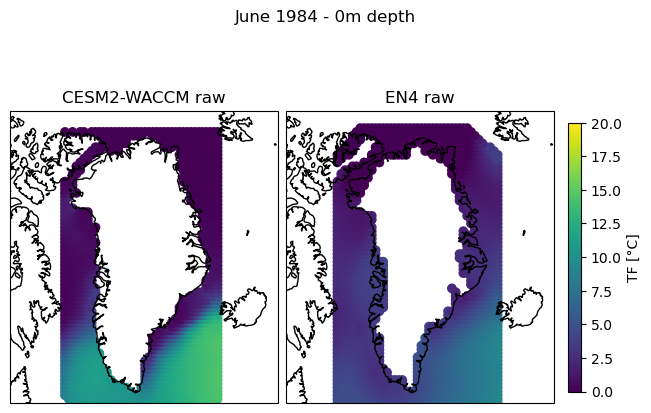

In [13]:
depth_toplot=0
TF_toplot_sim = test_ds_full.TF.sel(time='1984-06-30', depth=depth_toplot, method='nearest')
TF_toplot_obs = tobs_ds_full.sel(time='1984-06-30', depth=depth_toplot, method='nearest')

# obs_x, obs_y = np.meshgrid(tobs_ds_full.lon, tobs_ds_full.lat)

### Limits of Greenland domain ###
limN           = 86.0 ## degrees N latitude
limS           = 57.0 ## degrees N latitude
limE           = 4.0 ## degrees E latitude
limW           = 274.0 ## degrees E latitude

GrIS_polar_stereo = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            false_easting=0.0,
            false_northing=0.0,
            true_scale_latitude=70.0,
            globe=ccrs.Globe('WGS84')
        )

fig, axs = plt.subplots(1,2, layout='constrained',
                        subplot_kw={'projection': GrIS_polar_stereo, 'extent':  [-65, -20, limS, limN]})

sc_sim = axs[0].scatter(y=test_ds_full.lat, x=test_ds_full.lon, 
                        c=TF_toplot_sim, transform=ccrs.PlateCarree(),
                        cmap='viridis', vmin=0., vmax=20.);
axs[0].set(aspect=1, title='CESM2-WACCM raw')
axs[0].coastlines()
# cbar1 = plt.colorbar(sc_sim, orientation='vertical', label='TF [°C]')

sc_obs = axs[1].scatter(y=TF_toplot_obs.lat, x=TF_toplot_obs.lon, 
                        c=TF_toplot_obs, transform=ccrs.PlateCarree(),
                        cmap='viridis', vmin=0., vmax=20.);
axs[1].set(aspect=1, title='EN4 raw')
axs[1].coastlines()
cbar2 = plt.colorbar(sc_obs, orientation='vertical', label='TF [°C]', shrink=0.6)

fig.suptitle('June 1984 - {}m depth'.format(depth_toplot))

## Apply QDM correction
We will apply the QDM correction on annual, de-trended series with the monthly residual variability re-applied afterward.

In [14]:
## name the datasets that came from xESMF (or bypassed it) to match what the rest of the code expects
tsim_match = test_ds_full
tobs_repr_match = tobs_ds_full

### Separate annual and monthly var

In [15]:
annual_ds = tsim_match.resample(time='YE').mean()

residual_ds = tsim_match.resample(time='ME').ffill() - annual_ds.resample(time='ME').ffill()

### Detrend the data to be fit
QDM performs poorly when values in the "projection" series exceed those seen in the "historical".  Detrend the future, historical, and reanalysis series before QDM correction.

In [16]:
def detrend_ser(da, dim, deg=1, var='tfdpavg0to500_bathymin100', return_fit=True):
    ## based on Gist by Ryan Abernathey
    ## hard coding Dataset version for now to make it behave with our datasets
    
    p = da.polyfit(dim=dim, deg=deg)
    
    if type(da) is xr.core.dataarray.DataArray:
        fit=xr.polyval(da[dim], p.polyfit_coefficients)
    elif type(da) is xr.core.dataset.Dataset:
        fit = xr.polyval(da[dim], p.TF_polyfit_coefficients) 
        ## eventually use `var` argument to take any variable of interest
        ## for now hard-coded the name of the depth-averaged thermal forcing, so this
        ## will fail if we change that name
    else:
        print("Unrecognized input type. Expected xarray DataArray or Dataset, got {}".format(type(da)))

    if return_fit==True: ## give back the fitted values to use in reconstructing a series
        return da-fit, fit
    else:
        return da-fit

detrended_obs = detrend_ser(tobs_repr_match.sel(time=slice(BaselinePeriod[0],BaselinePeriod[1])).resample(time='A').mean(),
                            dim='time',
                            deg=1)[0]

detrended_simh = detrend_ser(annual_ds.sel(time=slice(BaselinePeriod[0], BaselinePeriod[1])),
                             dim='time',
                             deg=1)[0]
# detrended_simp = detrend_ser(annual_ds.sel(time=slice(annual_ds.time[0], BaselinePeriod[0])),
#                              dim='time',
#                              deg=1)[0]

## correct the full time series
detrended_simp = detrend_ser(annual_ds,
                             dim='time',
                             deg=1)[0]


/Users/eultee/miniforge3/envs/odata/lib/python3.13/site-packages/xarray/groupers.py:498: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [17]:
## produce the QDM fit on detrended data
qdm_detrended = apply_cmfunc(
        method = "quantile_delta_mapping",
        obs = detrended_obs,
        simh = detrended_simh.rename({'time':'t_simh'}).chunk(dict(t_simh=-1)),
        simp = detrended_simp.chunk(dict(time=-1)),
        n_quantiles = 100,
        input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
        kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
    )

In [18]:
## reconstruct dataset from reanalysis mean val, future trend, QDM, and monthly residual
reanalysis_meanval = tobs_repr_match.sel(time=slice(BaselinePeriod[0], BaselinePeriod[1])).mean(dim='time')
CESM_meanval = annual_ds.sel(time=slice(BaselinePeriod[0], BaselinePeriod[1])).mean(dim='time')

## The same structure applies whether a future or past period
baseline_trendonly = detrend_ser(annual_ds,
                             dim='time',
                             deg=1)[1]

baseline_trend_series = reanalysis_meanval - CESM_meanval + baseline_trendonly ## remove model mean and replace it with reanalysis

qdm_dtr_series = qdm_detrended.TF
qdm_plus_resid = baseline_trend_series.resample(time='ME').ffill() + qdm_dtr_series.resample(time='ME').ffill() + residual_ds.TF


qdm_plus_resid

<xarray.Dataset> Size: 3GB
Dimensions:  (depth: 41, y: 73, x: 43, time: 3001)
Coordinates:
  * depth    (depth) float32 164B 0.0 50.0 100.0 ... 1.9e+03 1.95e+03 2e+03
  * y        (y) float32 292B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
  * x        (x) float32 172B -7.2e+05 -6.8e+05 -6.4e+05 ... 9.2e+05 9.6e+05
  * time     (time) datetime64[ns] 24kB 1850-12-31 1851-01-31 ... 2100-12-31
    lat      (y, x) float32 13kB 58.27 58.34 58.4 58.46 ... 80.34 80.03 79.72
    lon      (y, x) float32 13kB -56.79 -56.15 -55.51 ... 12.07 13.22 14.3
Data variables:
    TF       (depth, y, x, time) float64 3GB dask.array<chunksize=(14, 25, 11, 1), meta=np.ndarray>

In [ ]:
qdm_plus_resid.mean().compute()

In [ ]:
test_ds_full.mean().compute()

Text(0.5, 0.98, '2050-01-30 - 200m depth')

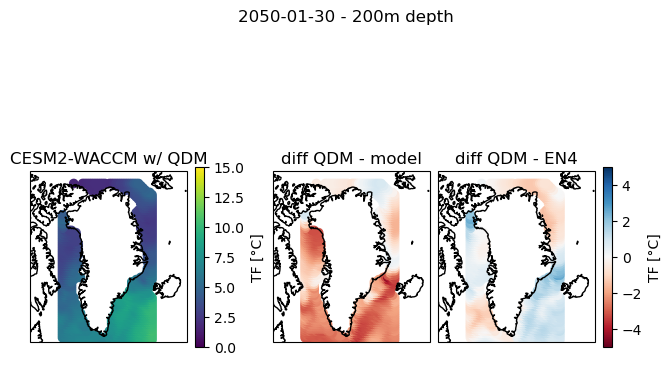

In [28]:
## what does it look like?

depth_toplot=200
date_toplot = '2050-01-30'
TF_toplot_sim = test_ds_full.TF.sel(time=date_toplot, depth=depth_toplot, method='nearest')
TF_toplot_obs = tobs_ds_full.sel(time=date_toplot, depth=depth_toplot, method='nearest')
TF_toplot_qdm = qdm_plus_resid.TF.sel(time=date_toplot, depth=depth_toplot, method='nearest')

# obs_x, obs_y = np.meshgrid(tobs_ds_full.lon, tobs_ds_full.lat)

### Limits of Greenland domain ###
limN           = 86.0 ## degrees N latitude
limS           = 57.0 ## degrees N latitude
limE           = 4.0 ## degrees E latitude
limW           = 274.0 ## degrees E latitude

GrIS_polar_stereo = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            false_easting=0.0,
            false_northing=0.0,
            true_scale_latitude=70.0,
            globe=ccrs.Globe('WGS84')
        )

fig, axs = plt.subplots(1,3, layout='constrained',
                        subplot_kw={'projection': GrIS_polar_stereo, 'extent':  [-65, -20, limS, limN]})

sc_qdm = axs[0].scatter(y=TF_toplot_qdm.lat, x=TF_toplot_qdm.lon, 
                        c=TF_toplot_qdm, transform=ccrs.PlateCarree(),
                        cmap='viridis', vmin=0., vmax=15.);
axs[0].set(aspect=1, title='CESM2-WACCM w/ QDM')
axs[0].coastlines()
cbar1 = plt.colorbar(sc_qdm, orientation='vertical', label='TF [°C]', shrink=0.4)

sc_simdiff = axs[1].scatter(y=TF_toplot_sim.lat, x=TF_toplot_sim.lon, 
                        c=TF_toplot_qdm-TF_toplot_sim, transform=ccrs.PlateCarree(),
                        cmap='RdBu', vmin=-5., vmax=5.);
axs[1].set(aspect=1, title='diff QDM - model')
axs[1].coastlines()
# cbar2 = plt.colorbar(sc_obs, orientation='vertical', label='TF [°C]', shrink=0.4)

sc_obsdiff = axs[2].scatter(y=TF_toplot_qdm.lat, x=TF_toplot_qdm.lon, 
                        c=TF_toplot_qdm-TF_toplot_obs, transform=ccrs.PlateCarree(),
                        cmap='RdBu', vmin=-5., vmax=5.);
axs[2].set(aspect=1, title='diff QDM - EN4')
axs[2].coastlines()
cbar2 = plt.colorbar(sc_obsdiff, orientation='vertical', label='TF [°C]', shrink=0.4)

fig.suptitle('{} - {}m depth'.format(date_toplot, depth_toplot))

In [26]:
## test write out
from datetime import datetime, date

now = datetime.now()
# ds_temp = qdm_plus_resid.to_dataset(name='TF')
ds_temp = qdm_plus_resid ## this one is already a dataset
ds_out = ds_temp.assign_attrs(title='QDM-corrected ocean thermal forcing for {}'.format(SelModel),
                             summary='TF computed following Verjans code, in a bounding' + 
                              ' box around Greenland, for ISMIP7 Greenland forcing. ' +
                              ' Additive QDM correction applied to annual based on Hadley data, with' +
                              ' monthly residual added',
                             institution='NASA Goddard Space Flight Center',
                             creation_date=now.strftime('%Y-%m-%d %H:%M:%S'))

ds_out

<xarray.Dataset> Size: 3GB
Dimensions:  (depth: 41, y: 73, x: 43, time: 3001)
Coordinates:
  * depth    (depth) float32 164B 0.0 50.0 100.0 ... 1.9e+03 1.95e+03 2e+03
  * y        (y) float32 292B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
  * x        (x) float32 172B -7.2e+05 -6.8e+05 -6.4e+05 ... 9.2e+05 9.6e+05
  * time     (time) datetime64[ns] 24kB 1850-12-31 1851-01-31 ... 2100-12-31
    lat      (y, x) float32 13kB 58.27 58.34 58.4 58.46 ... 80.34 80.03 79.72
    lon      (y, x) float32 13kB -56.79 -56.15 -55.51 ... 12.07 13.22 14.3
Data variables:
    TF       (depth, y, x, time) float64 3GB dask.array<chunksize=(14, 25, 11, 1), meta=np.ndarray>
Attributes:
    title:          QDM-corrected ocean thermal forcing for CESM2-WACCM
    summary:        TF computed following Verjans code, in a bounding box aro...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-09-19 15:31:10

In [27]:
if PressureIncluded:
    p_tag = 'IncludingPressure'
else:
    p_tag = 'NoPressure'
out_fn = DirSave + '/tfQDM_additive-AllLevels-CommonGrid-{}-{}_{}-{}-{}.nc'.format(SelModel, 
                                                            YearsIncluded[0], YearsIncluded[1],
                                                            p_tag,
                                                            now.strftime('%Y%m%d'))

from dask.diagnostics import ProgressBar

with ProgressBar():
    ds_out.to_netcdf(path=out_fn)

[########################################] | 100% Completed | 19m 20s
